In [22]:
import pandas as pd

# 加载数据： 读取训练集和测试集数据。
train_data = pd.read_csv('titanic/train.csv')
test_data = pd.read_csv('titanic/test.csv')
# 数据探索： 对数据进行初步的探索，查看数据的结构、缺失值和统计信息。
print(train_data.info())
print(train_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

In [23]:
print("train_data:")
print(train_data.isnull().sum())
print("\ntest_data:")
print(test_data.isnull().sum())

train_data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

test_data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [24]:
# 利用随机森林算法，借助其他属性值，来预测缺失数据值。
from sklearn.ensemble import RandomForestRegressor

def set_missing_age(df):
    # 把数值类型特征取出来，放入随机森林中进行训练
    age_df = df[['Age','Fare','Parch','SibSp','Pclass']]
    # 乘客分成已知年龄和未知年龄两个部分
    known_age = age_df[age_df.Age.notnull()].values
    unknown_age = age_df[age_df.Age.isnull()].values
    # 目标数据y
    y = known_age[:,0]
    # 特征属性数据x
    x = known_age[:,1:]
    # 利用随机森林进行拟合
    rfr = RandomForestRegressor(random_state=0,n_estimators=2000,n_jobs=-1)
    rfr.fit(x,y)
    # 利用训练的模型进行预测
    predictedAges = rfr.predict(unknown_age[:,1::])
    # 填补缺失的原始数据
    df.loc[(df.Age.isnull()),'Age'] = predictedAges
    return df

# 登陆港口属性缺失值仅有两条记录，数据量小，我们直接删除这两条记录。
def set_missing_embarked(df):
    return df.drop(df[df.Embarked.isnull()].index)


# 年龄缺失值填充
train_data = set_missing_age(train_data)
# print(train_data.head())
# train_data = set_missing_embarked(train_data)
data = set_missing_embarked(train_data)
train_data = set_missing_embarked(train_data)
print("train_data:")
# print(data.head())
print(train_data.isnull().sum())

train_data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


In [25]:
# 将 'Fare' 列中的缺失值填充为0
test_data['Fare'].fillna(0, inplace=True)
test_data = set_missing_age(test_data)
print("test_data:")
print(test_data.isnull().sum())

test_data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [26]:
# 因为最终的预测是二分类问题，所以我们初步选择逻辑回归模型进行预测，我们需要对属性中类别型的数据做因子化处理，而票价属性则相应的需要做归一化处理。
import sklearn.preprocessing as preprocessing
# 特征因子化
def set_numeralization(data):
    # 针对定类性属性进行因子化，分别有Embarked,Sex,Pclass
    dummies_Embarked = pd.get_dummies(data['Embarked'], prefix='Embarked')
    dummies_Embarked = dummies_Embarked.astype(int)
    dummies_Sex = pd.get_dummies(data['Sex'], prefix='Sex')
    dummies_Sex = dummies_Sex.astype(int)
    dummies_Pclass = pd.get_dummies(data['Pclass'], prefix='Pclass')
    dummies_Pclass = dummies_Pclass.astype(int)

    # 将新的属性拼合
    df = pd.concat([data, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
    # 将旧的属性剔除
    df.drop(['Pclass', 'Sex', 'Embarked'], axis=1, inplace=True)
    return df

# 特征归一化
def set_normalization(df):
    scaler = preprocessing.StandardScaler()
    age_scale_param = scaler.fit(df['Age'].values.reshape(-1,1))
    df['Age_scaled'] = scaler.fit_transform(df['Age'].values.reshape(-1,1),age_scale_param)
    fare_scale_param = scaler.fit(df['Fare'].values.reshape(-1,1))
    df['Fare_scaled'] = scaler.fit_transform(df['Fare'].values.reshape(-1,1),fare_scale_param)
    return df

# 特征工程
data = set_numeralization(data)
data = set_normalization(data)
print("data:")
print(data.head())
origin_train_data = train_data
train_data = set_numeralization(train_data)
train_data = set_normalization(train_data)
print("train_data:")
print(train_data.head())
test_data = set_numeralization(test_data)
test_data = set_normalization(test_data)
print("test_data:")
print(test_data.head())

data:
   PassengerId  Survived                                               Name  \
0            1         0                            Braund, Mr. Owen Harris   
1            2         1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3         1                             Heikkinen, Miss. Laina   
3            4         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5         0                           Allen, Mr. William Henry   

    Age  SibSp  Parch            Ticket     Fare Cabin  Embarked_C  \
0  22.0      1      0         A/5 21171   7.2500   NaN           0   
1  38.0      1      0          PC 17599  71.2833   C85           1   
2  26.0      0      0  STON/O2. 3101282   7.9250   NaN           0   
3  35.0      1      0            113803  53.1000  C123           0   
4  35.0      0      0            373450   8.0500   NaN           0   

   Embarked_Q  Embarked_S  Sex_female  Sex_male  Pclass_1  Pclass_2  Pclass_3  \
0           0    

In [27]:
import numpy as np
from sklearn import linear_model

# 利用正则表达式取出需要的属性
# print(train_data.head())
train_df = train_data.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Embarked_.*|Sex_.*|Pclass_.*')
# print(train_df.head())
train_np = train_df.values

test_df = test_data.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Embarked_.*|Sex_.*|Pclass_.*')
# print(test_df.head())

# 获取y
y = train_np[:,0]
# 获取自变量x
x = train_np[:,1:]

# 利用逻辑回归进行拟合,得到训练的模型
clf = linear_model.LogisticRegression(solver='liblinear',C=1.0,penalty='l2',tol=1e-6)
clf.fit(x,y.astype('int'))

# 对测试数据进行预测
predictions = clf.predict(test_df)
result = pd.DataFrame({'PassengerId':test_data['PassengerId'].values,'Survived':predictions.astype(np.int32)})
print(result.head())

# 模型中各属性的系数（用于分析各特征的贡献度）
feature_corr = pd.DataFrame({'columns':list(train_df.columns)[1:],'coef':list(clf.coef_.T)})
print(feature_corr)

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
        columns                   coef
0         SibSp   [-0.355431903199446]
1         Parch   [-0.094202530409165]
2    Embarked_C  [0.20430454979372842]
3    Embarked_Q  [0.21577792957672398]
4    Embarked_S  [-0.1959817085879947]
5    Sex_female   [1.4268029315909248]
6      Sex_male  [-1.2027021608084667]
7      Pclass_1   [1.1355267510911224]
8      Pclass_2   [0.1599259164631814]
9      Pclass_3  [-1.0713518967718272]
10   Age_scaled  [-0.5383879022697289]
11  Fare_scaled   [0.1130476323940343]


D:\Applications\anaconda\envs\Titanic\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [28]:
feature_corr = pd.DataFrame({'columns': list(train_df.columns)[1:], 'coef': clf.coef_.flatten()})
print(feature_corr)

        columns      coef
0         SibSp -0.355432
1         Parch -0.094203
2    Embarked_C  0.204305
3    Embarked_Q  0.215778
4    Embarked_S -0.195982
5    Sex_female  1.426803
6      Sex_male -1.202702
7      Pclass_1  1.135527
8      Pclass_2  0.159926
9      Pclass_3 -1.071352
10   Age_scaled -0.538388
11  Fare_scaled  0.113048


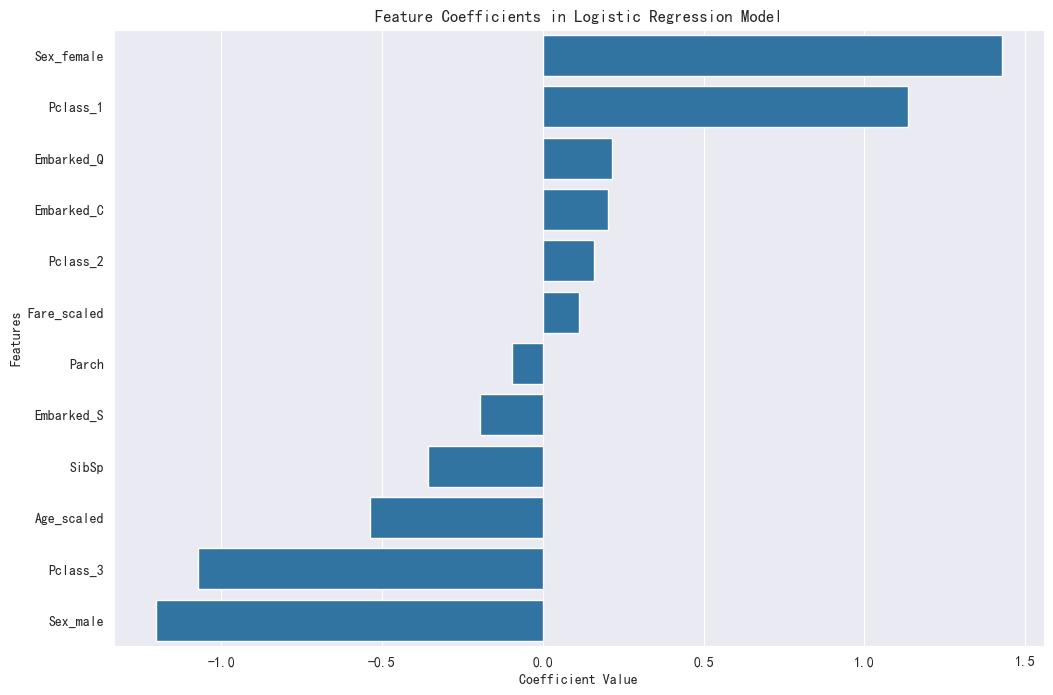

In [29]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 排序feature_corr，以便更好地可视化
feature_corr_sorted = feature_corr.sort_values(by='coef', ascending=False)

# 创建条形图
plt.figure(figsize=(12, 8))
# print(type(feature_corr_sorted))
sns.barplot(x='coef', y='columns', data=feature_corr_sorted)

# 设置图形标题和标签
plt.title('Feature Coefficients in Logistic Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')

# 显示图形
matplotlib.rcParams['axes.unicode_minus'] =False
plt.show()

In [30]:
from sklearn.model_selection import cross_val_score
train_df = train_data.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Embarked_.*|Sex_.*|Pclass_.*')
print(train_df.head)
train_np = train_df.values
# 获取y
y = train_np[:, 0]
# 获取自变量x
x = train_np[:, 1:]

# 利用逻辑回归进行拟合,得到训练的模型
clf = linear_model.LogisticRegression(solver='liblinear', C=1.0, penalty='l2', tol=1e-6)
clf.fit(x, y.astype('int'))

# 交叉检验
score = cross_val_score(clf, x, y.astype('int'), cv=5, scoring='accuracy')
print(score)
print(score.mean())

<bound method NDFrame.head of      Survived  SibSp  Parch  Embarked_C  Embarked_Q  Embarked_S  Sex_female  \
0           0      1      0           0           0           1           0   
1           1      1      0           1           0           0           1   
2           1      0      0           0           0           1           1   
3           1      1      0           0           0           1           1   
4           0      0      0           0           0           1           0   
..        ...    ...    ...         ...         ...         ...         ...   
886         0      0      0           0           0           1           0   
887         1      0      0           0           0           1           1   
888         0      1      2           0           0           1           1   
889         1      0      0           1           0           0           0   
890         0      0      0           0           1           0           0   

     Sex_male  Pclass

In [40]:
# 对于SibSp属性，我们划分成0,1~2，3~8三个等级
data['SibSp_cut'] = 1
data.loc[data['SibSp'] == 0, 'SibSp_cut'] = 0
data.loc[data['SibSp'] >= 3, 'SibSp_cut'] = 2

# 对于Parch属性，我们划分成0,1~3，4~6三个等级
data['Parch_cut'] = 1
data.loc[data['Parch'] == 0, 'Parch_cut'] = 0
data.loc[data['Parch'] > 3, 'Parch_cut'] = 2

# 因子化处理
dummies_SibSp = pd.get_dummies(data['SibSp_cut'], prefix='SibSp')
dummies_Parch = pd.get_dummies(data['Parch_cut'], prefix='Parch')
data.drop(['SibSp_cut', 'Parch_cut'], axis=1, inplace=True)

dummies_SibSp = dummies_SibSp.astype('int')
dummies_Parch = dummies_Parch.astype('int')

# 数据归一化
# transfer = preprocessing.MinMaxScaler(feature_range=[0, 1])
transfer = preprocessing.MinMaxScaler(feature_range=(0, 1))
data['Age_scaled'] = transfer.fit_transform(data['Age'].values.reshape(-1, 1))
data['Fare_scaled'] = transfer.fit_transform(data['Fare'].values.reshape(-1, 1))

# 数据合并
df = pd.concat([data, dummies_SibSp, dummies_Parch], axis=1)

# 特征筛选
train_data = df.filter(regex='Survived|Age_.*|SibSp_.*|Parch_.*|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
print(train_data.head())

# 模型的交叉检验
train_np = train_data.values
# 获取y
y = train_np[:, 0]
# 获取自变量x
x = train_np[:, 1:]

# 利用逻辑回归进行拟合,得到训练的模型
clf = linear_model.LogisticRegression(solver='liblinear', C=1.0, penalty='l2', tol=1e-6)
clf.fit(x, y.astype('int'))

feature_corr = pd.DataFrame({'columns': list(train_data.columns)[1:], 'coef': list(clf.coef_.T)})
print(feature_corr)

# 交叉检验
score = cross_val_score(clf, x, y.astype('int'), cv=5, scoring='accuracy')
print(score)
print(score.mean())

   Survived  Embarked_C  Embarked_Q  Embarked_S  Sex_female  Sex_male  \
0         0           0           0           1           0         1   
1         1           1           0           0           1         0   
2         1           0           0           1           1         0   
3         1           0           0           1           1         0   
4         0           0           0           1           0         1   

   Pclass_1  Pclass_2  Pclass_3  Age_scaled  Fare_scaled  SibSp_0  SibSp_1  \
0         0         0         1    0.271174     0.014151        0        1   
1         1         0         0    0.472229     0.139136        0        1   
2         0         0         1    0.321438     0.015469        1        0   
3         1         0         0    0.434531     0.103644        0        1   
4         0         0         1    0.434531     0.015713        1        0   

   SibSp_2  Parch_0  Parch_1  Parch_2  
0        0        1        0        0  
1        0  

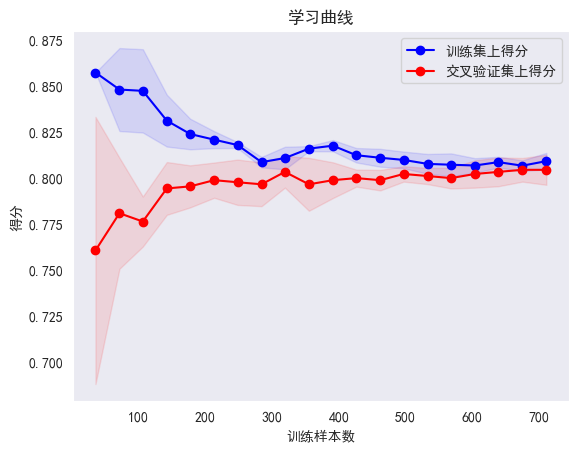

In [32]:
from sklearn.model_selection import learning_curve
from pylab import mpl


# 绘制学习曲线
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,
                        train_sizes=np.linspace(.05, 1.0, 20), verbose=0, plot=True):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    if plot:
        mpl.rcParams["font.sans-serif"] = ["SimHei"]
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"训练样本数")
        plt.ylabel(u"得分")
        plt.gca().invert_yaxis()
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"训练集上得分")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"交叉验证集上得分")

        plt.legend(loc="best")

        plt.draw()
        plt.gca().invert_yaxis()
        plt.show()

# train_np = data_train.values
# 获取y
y = train_np[:, 0]
# 获取自变量x
X = train_np[:, 1:]

clf = linear_model.LogisticRegression(solver='liblinear', C=1.0, penalty='l2', tol=1e-6)
clf.fit(X, y.astype('int'))
plot_learning_curve(clf, u"学习曲线", X, y.astype('int'))

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 划分训练集和验证集
X_train, X_valid, y_train, y_valid = train_test_split(x, y.astype('int'), test_size=0.2, random_state=42)

# 创建随机森林模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 拟合模型
rf_model.fit(X_train, y_train)

# 预测验证集
rf_predictions = rf_model.predict(X_valid)

# 计算准确率
rf_accuracy = accuracy_score(y_valid, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.7752808988764045


In [34]:
from sklearn.model_selection import cross_val_score

# 使用交叉验证计算准确率
cross_val_scores = cross_val_score(rf_model, x, y.astype('int'), cv=5)
print("Cross-Validation Scores:", cross_val_scores)
print("Mean Cross-Validation Score:", cross_val_scores.mean())

Cross-Validation Scores: [0.79213483 0.79213483 0.85393258 0.7752809  0.83615819]
Mean Cross-Validation Score: 0.8099282676315622


In [35]:
from sklearn.model_selection import GridSearchCV

# 定义超参数的范围
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4]
}

# 创建随机森林模型
rf_model = RandomForestClassifier(random_state=42)

# 使用网格搜索进行调参
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# 输出最佳超参数
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}


In [36]:
# 使用最佳超参数创建最终的随机森林模型
best_max_depth, best_min_samples_leaf, best_params_n_estimators = grid_search.best_params_['max_depth'], grid_search.best_params_['min_samples_leaf'], grid_search.best_params_['n_estimators']
# print(type(grid_search.best_params_))
# print(best_max_depth, best_min_samples_leaf)
# 手动测试发现最大深度5优于上面算出来的最大深度10
final_rf_model = RandomForestClassifier(n_estimators=best_params_n_estimators, max_depth=5, 
                                        min_samples_leaf=best_min_samples_leaf, random_state=42)
# 拟合最终模型
final_rf_model.fit(X_train, y_train)

# 在测试集上进行预测
final_predictions = final_rf_model.predict(X_valid)
# 创建包含预测结果的 DataFrame
# print(X_valid)
# final_result = pd.DataFrame({'PassengerId': X_valid['PassengerId'].values, 'Survived': final_predictions.astype(np.int32)})
# 输出前几行预测结果
# print(final_result.head())
# 计算测试集上的准确率
final_accuracy = accuracy_score(y_valid, final_predictions)
print("Final Test Set Accuracy:", final_accuracy)

Final Test Set Accuracy: 0.8202247191011236


In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# # 假设选择 'Pclass', 'Age', 'SibSp', 'Sex', 'Fare' 作为特征
# features = ['Pclass', 'Age', 'Fare', 'Sex', 'SibSp']
# X = origin_train_data[features]
# y = origin_train_data['Survived']


train_df = train_data.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.values
# 获取y
y = train_np[:,0].astype('int')
# 获取自变量x
x = train_np[:,1:]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# 创建支持向量机模型
svm_model = SVC(kernel='linear', C=1, random_state=42)
# 拟合模型
svm_model.fit(X_train, y_train)
# 预测测试集
svm_predictions = svm_model.predict(X_test)
# 计算准确率
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

SVM Accuracy: 0.797752808988764


In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

train_df = train_data.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.values
# 获取y
y = train_np[:,0].astype('int')
# 获取自变量x
x = train_np[:,1:]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# 创建KNN模型
knn_model = KNeighborsClassifier(n_neighbors=2)
# 拟合模型
knn_model.fit(X_train, y_train)
# 预测测试集
knn_predictions = knn_model.predict(X_test)
# 计算准确率
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy:", knn_accuracy)

KNN Accuracy: 0.797752808988764


In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import layers

train_df = train_data.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Embarked_.*|Sex_.*|Pclass_.*')
print(train_data)
train_np = train_df.values
# 获取y
y = train_np[:,0].astype('int')
# 获取自变量x
x = train_np[:,1:]
print(x)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 构建神经网络模型
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# 在测试集上评估模型
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)  # 将概率转换为二进制类别
accuracy = accuracy_score(y_test, predictions)
print("Neural Network Accuracy:", accuracy)

     Survived  Embarked_C  Embarked_Q  Embarked_S  Sex_female  Sex_male  \
0           0           0           0           1           0         1   
1           1           1           0           0           1         0   
2           1           0           0           1           1         0   
3           1           0           0           1           1         0   
4           0           0           0           1           0         1   
..        ...         ...         ...         ...         ...       ...   
886         0           0           0           1           0         1   
887         1           0           0           1           1         0   
888         0           0           0           1           1         0   
889         1           1           0           0           0         1   
890         0           0           1           0           0         1   

     Pclass_1  Pclass_2  Pclass_3  Age_scaled  Fare_scaled  SibSp_0  SibSp_1  \
0           0      